<a href="https://colab.research.google.com/github/deeppaco/logo_detection_project/blob/main/two_stage_detectors/FasterRCNN_logo_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installations and Mounting


!!! CHANGE THE BASE DIRECTORY IN CODE BELOW TO RUN THIS SCRIPT !!!

In [3]:
"""
Define base director where data sits 
"""
import os, sys
from google.colab import drive
import json

#SPECIFY FILE PATH HERE
path = PATH_OF_GITHUBFOLDER
base_dir = path + "/two_stage_detectors"
#base_dir = "/content/drive/MyDrive/bocconi_python_codes/Computer_Vision_Codes/Project_Option_Detection"
data_dir = base_dir + "/Data/"

In [39]:
int2str = {1: 'Nike',
 2: 'Adidas',
 3: 'Under Armour',
 4: 'Puma',
 5: 'The North Face',
 6: 'Starbucks',
 7: 'Apple Inc-',
 8: 'Mercedes-Benz',
 9: 'NFL',
 10: 'Coca-Cola',
 11: 'Hard Rock Cafe'}

In [5]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 209 kB 73.5 MB/s 
     |████████████████████████████████| 80 kB 11.7 MB/s 
     |████████████████████████████████| 75 kB 6.0 MB/s 
     |████████████████████████████████| 112 kB 80.8 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
     |████████████████████████████████| 149 kB 97.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=a183468cebd46a4561dc3418e99180e861a2612498f6ed5ebb4d262d8f1d9f7a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [6]:
!pip install pyyaml==5.1

     |████████████████████████████████| 274 kB 4.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=459bac2d588277dbfd7a341ee2a9bfebf889924a68f1935c3737e5572ecd0958
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
sys.path.append(base_dir + '/TorchDetectionHelpers/')


In [8]:
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import matplotlib.image as mpimg


from collections import Counter

import torch
import argparse

import torch.nn as nn

from tqdm import tqdm
from torch import optim
from torchvision import transforms as t
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [9]:
"""
Magma color palette as standard for the notebook
"""
color_palette = sns.color_palette("magma", 20)

### Plot Functions


In [93]:
"""
Count plot of the different labels
"""


def count_plot(df, count_col):
  counts = df.groupby(count_col).size().sort_values(ascending = False)

  fig,ax = plt.subplots(figsize = (10,4))
  labels = counts.index
  sns.barplot(x = labels, y = counts.values, ax = ax,palette= color_palette[5:])
  ax.set_xticklabels(labels = labels, rotation=70, horizontalalignment= 'right')
  ax.set_title("Counts of the different classes")
  return counts


In [92]:
"""
Boxplot of area distribution across the different labels
"""

def dist_by_class(df, label_col, dist_col):
  fig, ax = plt.subplots(figsize = (10,6))
  labels = df[label_col].unique()

  sns.boxplot(x = df[label_col],y = df[dist_col], ax = ax, palette=color_palette[5:])

  ax.set_xticklabels(labels = labels, rotation=70, horizontalalignment= 'right')
  ax.set_title(f"Boxplot of {dist_col} distribution of bounding boxes by label")

In [12]:
"""
Support function to add the bounding box into an image plot
"""
def show_box(row, col, **kwargs):    
    if row[col]:
      box = row[col]
      x, y = box[0],box[1]
      width,height = box[2], box[3]
      rect = patches.Rectangle((x, y),
                                      width, height,
                                      **kwargs)
      ax.add_patch(rect)



### Analysis pre Roboflow


In [13]:
"""
Read in the original csv file 
"""
pre_roboflow_data = pd.read_csv(data_dir + "annot_train.csv")
pre_roboflow_data.head()

photo_filename  width  height  ... ymin  xmax  ymax
0  charlotte_1019088214340003257_20150630.jpg    640     640  ...  394   381   439
1  charlotte_1056018576661922536_20150820.jpg    640     640  ...    0   574    30
2  charlotte_1057610050380125945_20150823.jpg   1080    1080  ...  406   473   477
3  charlotte_1061715143228072770_20150828.jpg   1080    1349  ...   51   330   198
4  charlotte_1081463278280976819_20150925.jpg    612     612  ...   30   580    69

[5 rows x 8 columns]

In [14]:
"""
Calculate the ratio of bounding box to image size
"""
pre_roboflow_data["size"] = pre_roboflow_data["width"] * pre_roboflow_data["height"]

pre_roboflow_data["bbox_size"] = (pre_roboflow_data["xmax"] - pre_roboflow_data["xmin"]) * (pre_roboflow_data["ymax"] - pre_roboflow_data["ymin"])
pre_roboflow_data["size_ratio"] = pre_roboflow_data["bbox_size"] / pre_roboflow_data["size"]

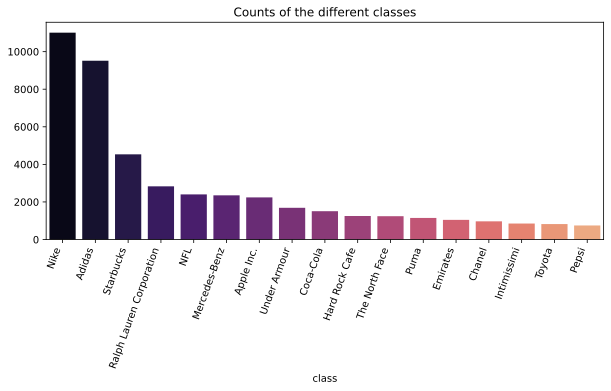

In [15]:
"""
Plot the distribution of data by class
"""
counts_pre = count_plot(pre_roboflow_data,"class")

The large existing class imbalance will require some form of upsampling the underrepresented classes in order to deal with this issue. More augmentation for underrepresented classes as well as additional labelling of new images will be used to partially resolve this issue. 

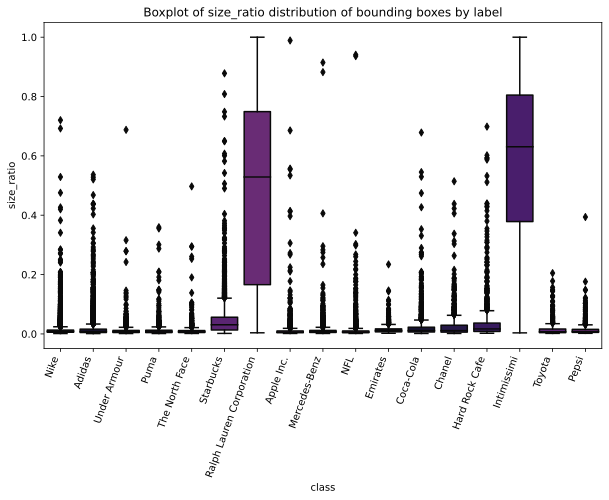

In [16]:
"""
Plot of the distribution of bounding box per class
"""
dist_by_class(pre_roboflow_data,"class","size_ratio")

The distributions of bounding box ratios for Ralph Lauren Corporation and Intimissimi are extremely large. Indeed an analysis of the pictures inside Roboflow revealed these images to be incorrectly labeled and hence its annotations are subsequently dropped. 

###Analysis on labels of the dataset

!!!This section can only be run with the train set available - Please write us to receive the training set!!!




In [19]:
import json

In [20]:
"""
Load in the training data information from json final
"""

with open("/content/data_COCO/train/_annotateFinal.json") as json_file:
  train_label_data = json.load(json_file)


In [21]:
"""
load in test data information from test json file  
"""

with open(data_dir + "data_COCO/test/_annotateFinal.json") as json_file:
  test_label_data = json.load(json_file)



In [22]:
"""
Json info to dataframe
"""
train_image_data_df = pd.DataFrame(train_label_data["images"])
train_label_data_df = pd.DataFrame(train_label_data["annotations"])

train_label_data_df.head()

id  image_id  category_id  ...       area  segmentation iscrowd
0   0         0            8  ...  9975.0000            []       0
1   1         1            8  ...  1205.3125            []       0
2   2         2            7  ...  4290.0000            []       0
3   3         4            8  ...  9407.4375            []       0
4   4         5            7  ...  3025.6250            []       0

[5 rows x 7 columns]

In [23]:
"""
Json info to dataframe
"""
test_image_data_df = pd.DataFrame(test_label_data["images"])
test_label_data_df = pd.DataFrame(test_label_data["annotations"])

test_label_data_df.head()

id  image_id  category_id  ...     area  segmentation iscrowd
0   0         0            7  ...  3611.25            []       0
1   1         1            9  ...  5973.00            []       0
2   2         2            7  ...  4658.50            []       0
3   3         3            9  ...  5037.50            []       0
4   4         6            8  ...  7179.50            []       0

[5 rows x 7 columns]

In [24]:
"""
Create mapping of integer to string of class labels
"""
int2str = {cat["id"]:cat["name"] for cat in train_label_data["categories"][1:]}

In [25]:
"""
Add string class name to the label dataframe
"""

train_label_data_df["label"] = train_label_data_df["category_id"].apply(lambda x: int2str[x])
test_label_data_df["label"] = test_label_data_df["category_id"].apply(lambda x: int2str[x])

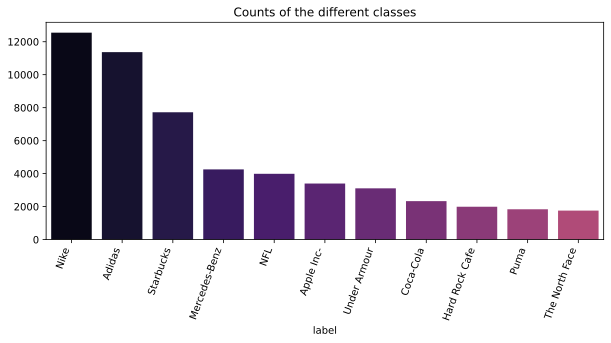

In [26]:
"""
Plot class distribution of train set
"""

counts_post_train = count_plot(train_label_data_df,"label")

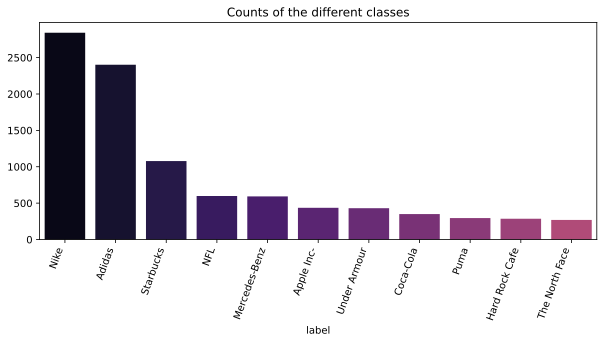

In [27]:
"""
...and test set 
"""

counts_post_test = count_plot(test_label_data_df,"label")

As highlighted above the distributions of the test and train splits are roughly the same, the only difference being that Nike and Adidas have comparatively less in the test set than the train set. This makes sense as less data augmentation was utilised on those two logos. 

In [28]:
"""
Lets check the bounding box ratios post preprocessing
"""

#Calculates bounding box area to image size ratio
train_label_data_df["bbox_ratio"] = train_label_data_df["area"]/(800**2)
test_label_data_df["bbox_ratio"] = test_label_data_df["area"]/(800**2)

train_label_data_df.head()

id  image_id  category_id  ... iscrowd          label bbox_ratio
0   0         0            8  ...       0  Mercedes-Benz   0.015586
1   1         1            8  ...       0  Mercedes-Benz   0.001883
2   2         2            7  ...       0     Apple Inc-   0.006703
3   3         4            8  ...       0  Mercedes-Benz   0.014699
4   4         5            7  ...       0     Apple Inc-   0.004728

[5 rows x 9 columns]

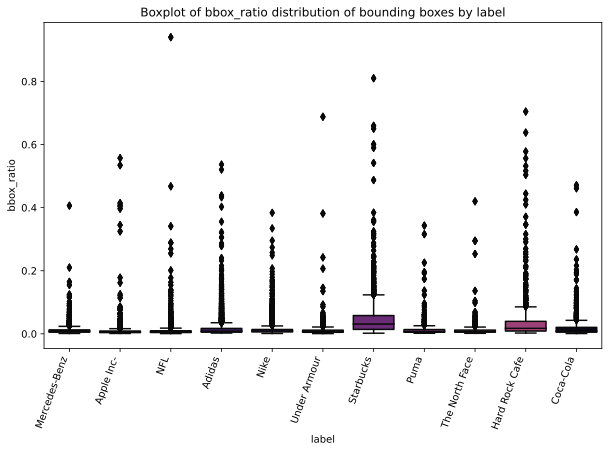

In [29]:
"""
Plot of bbox ratio distribution for train set
"""
dist_by_class(train_label_data_df,"label","bbox_ratio")

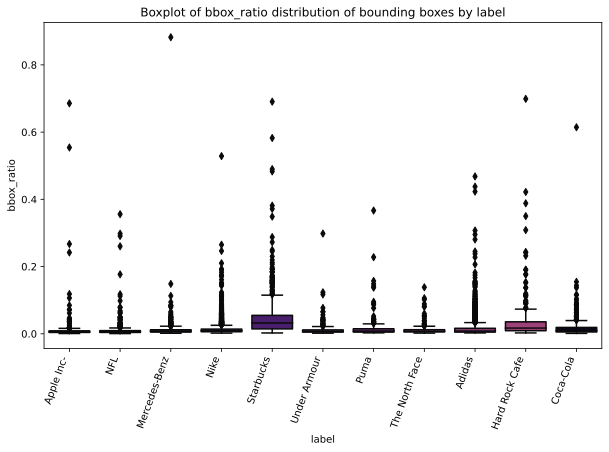

In [30]:
"""
Plot of bbox ratio distribution for test set
"""

dist_by_class(test_label_data_df,"label","bbox_ratio")

Some of the largest outliers might be bad labeling and hence it is considered safer to remove and annotations with bounding boxes larger than 0.4. 

In [31]:
"""
Lets remove any labels with a bounding box >= X% 
"""
train_label_data_df = train_label_data_df.loc[train_label_data_df["bbox_ratio"] < 0.4].copy()
test_label_data_df = test_label_data_df.loc[test_label_data_df["bbox_ratio"] < 0.4].copy()

In [32]:
def print_info(df_image,df_labels, name = "Train"):
  print('\033[1m' + f"{name} Stats: " + '\033[0m')
  print(" ")
  print(f"N Images: {len(df_image)}")
  print("-"*50)
  print(f"N labelled Images: {len(df_labels)}")
  print("-"*50)
  print(f"Fraction of labelled data: {np.round(len(df_labels)/len(df_image),6)}%")

print_info(train_image_data_df,train_label_data_df)

Train Stats: 
 
N Images: 67956
--------------------------------------------------
N labelled Images: 54201
--------------------------------------------------
Fraction of labelled data: 0.79759%


In [33]:
print_info(test_image_data_df,test_label_data_df, "Test")

Test Stats: 
 
N Images: 11452
--------------------------------------------------
N labelled Images: 9565
--------------------------------------------------
Fraction of labelled data: 0.835225%


In [34]:
"""
Lets explore the Aspect Ratios of the images to generate some optimal Anchoring
"""

train_label_data_df["width"] = train_label_data_df["bbox"].apply(lambda x: x[2])
train_label_data_df["height"] = train_label_data_df["bbox"].apply(lambda x: x[3])
train_label_data_df["aspect_ratio"] = train_label_data_df["height"] / train_label_data_df["width"]
train_label_data_df.head()

id  image_id  category_id  ...  width  height aspect_ratio
0   0         0            8  ...  99.75  100.00     1.002506
1   1         1            8  ...  33.25   36.25     1.090226
2   2         2            7  ...  65.00   66.00     1.015385
3   3         4            8  ...  98.25   95.75     0.974555
4   4         5            7  ...  58.75   51.50     0.876596

[5 rows x 12 columns]

In [35]:
"""
test data aspect ratios
"""
test_label_data_df["width"] = test_label_data_df["bbox"].apply(lambda x: x[2])
test_label_data_df["height"] = test_label_data_df["bbox"].apply(lambda x: x[3])
test_label_data_df["aspect_ratio"] = test_label_data_df["height"] / test_label_data_df["width"]

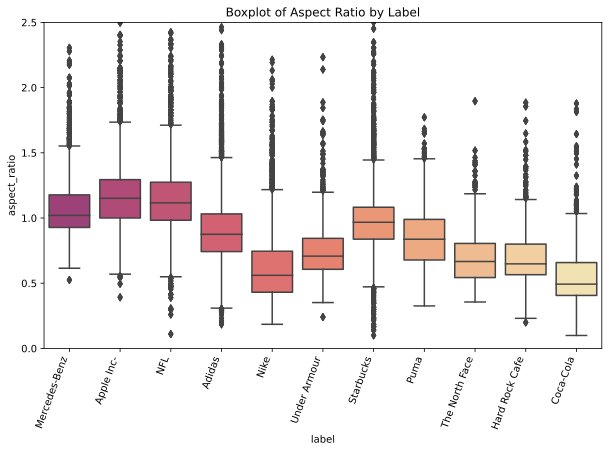

In [36]:
"""
Distribution plot of bbox ratio
"""

def plot_aspect_ratio(df):
  fig, ax = plt.subplots(figsize = (10,6))
  sns.boxplot(x = "label", y= "aspect_ratio", data = df,palette = color_palette[9:],ax = ax)
  ax.set_xticklabels(df["label"].unique(),rotation = 70, horizontalalignment = "right")
  ax.set_ylim(0,2.5)
  ax.set_title("Boxplot of Aspect Ratio by Label")

plot_aspect_ratio(train_label_data_df)

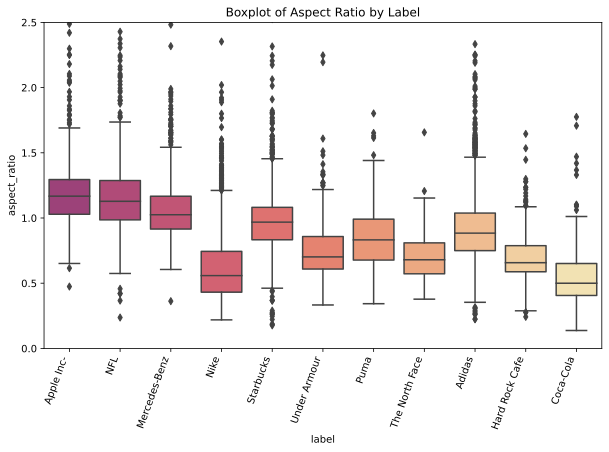

In [37]:
plot_aspect_ratio(test_label_data_df)

In [38]:
test_label_data_df["aspect_ratio"].describe(percentiles = np.arange(0.05,1,0.05))

count    9565.000000
mean        0.840758
std         0.325645
min         0.137441
5%          0.396329
10%         0.435925
15%         0.488849
20%         0.552431
25%         0.601744
30%         0.651446
35%         0.696353
40%         0.738845
45%         0.776639
50%         0.817241
55%         0.855064
60%         0.899027
65%         0.939327
70%         0.983044
75%         1.025937
80%         1.075153
85%         1.136067
90%         1.238095
95%         1.398693
max         4.444444
Name: aspect_ratio, dtype: float64

As can be shown there are considerable differences in the sizes of the bounding aspect ratios across the different level. Generally however, the aspect rations are centered somewhere between 0.5 and 1 in terms of height/width. This makes sense as most of the logos contain some text and are therefore longer in width. However, as there is quite a spread distribution overall inbetween rations of 0.2 and 1.5 a wide range of values within this level will be considered for the region proposals generated by Faster RCNN

In [39]:
"""
Write back the adjusted labels to the dcitionaries file
"""

train_label_data["annotations"] = train_label_data_df[train_label_data["annotations"][0].keys()].to_dict("records")
test_label_data["annotations"] = test_label_data_df[test_label_data["annotations"][0].keys()].to_dict("records")



####Remove noise data 

Noise data arising from some labels that have not been chosen, e.g. Chanel, Toyota etc - needs to be removed as were distorting results - too often images classified as background otherwise. 

In [40]:
"""
Columns that need to be written back to json later
"""
image_keys = train_label_data["images"][0].keys()


In [41]:
"""
Adjust the file name to match the original so we can get back the omitted class tags
"""

train_image_data_df["file_name_original"] = train_image_data_df["file_name"].apply(lambda x: ".".join(x.split(".")[0].rsplit("_", 1)))
test_image_data_df["file_name_original"] = test_image_data_df["file_name"].apply(lambda x: ".".join(x.split(".")[0].rsplit("_", 1)))

test_image_data_df.head()

id  ...                        file_name_original
0   0  ...       la_1095824318101355209_20151014.jpg
1   1  ...  chicago_1242308820500878747_20160503.jpg
2   2  ...       la_1297415163356319418_20160718.jpg
3   3  ...  chicago_1443238891511818927_20170205.jpg
4   4  ...    miami_1576246283147038957_20170807.jpg

[5 rows x 7 columns]

In [42]:
"""
Merge the labeling to the image dataframe
"""
#Train Data
train_image_data_df = pd.merge(
    train_image_data_df, 
    pre_roboflow_data[["photo_filename", "class"]], 
    left_on="file_name_original", right_on = "photo_filename", 
    how = "left")


#Test Data
test_image_data_df = pd.merge(test_image_data_df, 
                              pre_roboflow_data[["photo_filename", "class"]], 
                              left_on="file_name_original", right_on = "photo_filename", 
                              how = "left")


In [43]:
train_image_data_df["class"] = train_image_data_df["class"].str.replace("Apple Inc.","Apple Inc-")
test_image_data_df["class"] = test_image_data_df["class"].str.replace("Apple Inc.","Apple Inc-")

In [44]:
"""
Get only the relevant logos
"""
train_image_data_df = train_image_data_df.loc[
                                              (train_image_data_df["class"] == "Ralph Lauren Corporation") |
                                              (train_image_data_df["class"] == "Intimissimi") |
                                              (train_image_data_df["class"].apply(lambda x: True if x in int2str.values() else False))
                                              ]

test_image_data_df = test_image_data_df.loc[
                                              (test_image_data_df["class"] == "Ralph Lauren Corporation") |
                                              (test_image_data_df["class"] == "Intimissimi") |
                                              (test_image_data_df["class"].apply(lambda x: True if x in int2str.values() else False))
                                              ]                 

In [45]:
"""
General stats on the train dataset
"""

print_info(train_image_data_df,train_label_data_df)

Train Stats: 
 
N Images: 61590
--------------------------------------------------
N labelled Images: 54201
--------------------------------------------------
Fraction of labelled data: 0.880029%


In [46]:
"""
... and test dataset
"""
print_info(test_image_data_df,test_label_data_df)

Train Stats: 
 
N Images: 10554
--------------------------------------------------
N labelled Images: 9565
--------------------------------------------------
Fraction of labelled data: 0.906291%


In [47]:
"""
Update the dictionaries with the correct data 
"""
train_label_data["images"]= train_image_data_df[image_keys].to_dict("records")
test_label_data["images"]= test_image_data_df[image_keys].to_dict("records")



In [48]:
"""
Write back to JSON
"""
with open("/content/data_COCO/train/_annotateFinalAdj.json", "w") as file: 
  json.dump(train_label_data, file) 

with open(data_dir + "data_COCO/test/_annotateFinalAdj.json", "w") as file: 
  json.dump(test_label_data, file) 

#### Plot Images

In [49]:
plot_df = pd.merge(test_image_data_df[["id", "file_name"]], test_label_data_df, left_on = "id", right_on = "image_id", how = "left")
nike_data = plot_df.loc[plot_df["label"] == "Nike"]

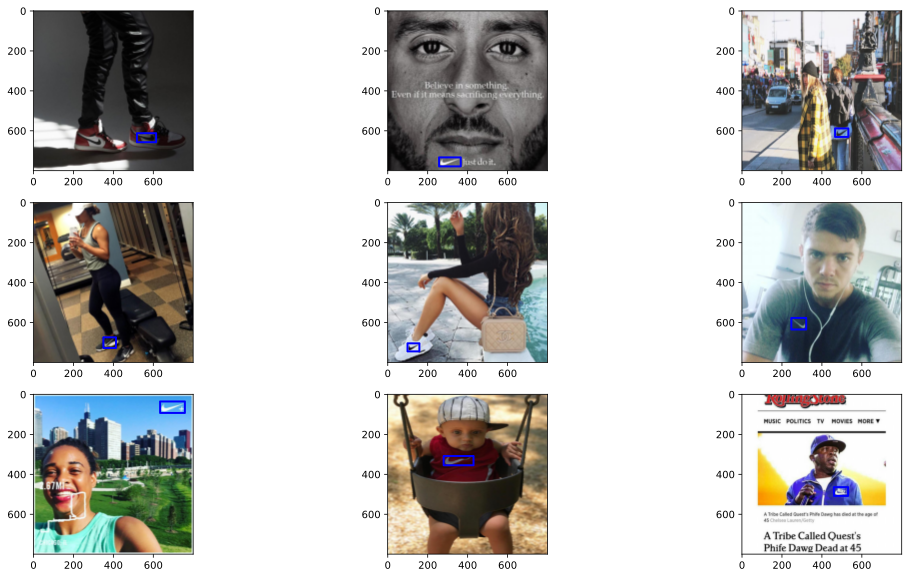

In [50]:
fig, axs = plt.subplots(3,3,figsize = (18,10))
import matplotlib.image as mpimg

rand = np.random.randint(0,1500)
for i, ax in enumerate(fig.axes):
  row = nike_data.iloc[i+rand]
  img = mpimg.imread(data_dir + "data_COCO/test/" + row["file_name"]) 

  show_box(row, "bbox",linewidth = 2,edgecolor = 'blue',facecolor = 'none')
  ax.imshow(img)

### Faster RCNN complete pytorch implementation from scratch

In [34]:
from DataClass import myOwnDataset
import sys 
from engine import train_one_epoch, evaluate

import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, RetinaNet
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch



In [17]:

sys.path.append(base_dir + "/TorchDetectionHelpers")
sys.path.append(base_dir)

In [18]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [20]:
"""
coco_data_train = myOwnDataset(root = "/content/data_COCO/train", annotation = "/content/data_COCO/train/_annotateFinalAdj.json",transforms=t.Compose([
                      t.ToTensor()
                  ]))

train_loader = torch.utils.data.DataLoader(coco_data_train,batch_size=12, shuffle=True,collate_fn = collate_fn)
"""
print("Loads train data - only possible on training")

Loads train data - only possible on training


In [22]:
coco_data_test = myOwnDataset(root =data_dir + "data_COCO/test", annotation = data_dir +"data_COCO/test/_annotateFinalAdj.json",transforms=t.Compose([
                      t.ToTensor()
                  ]))

test_loader = torch.utils.data.DataLoader(coco_data_test,batch_size=12, shuffle=True,collate_fn = collate_fn)

loading annotations into memory...
Done (t=11.64s)
creating index...
index created!


In [23]:
import cv2

import matplotlib.patches as patches

def show_true_box(img,annots):
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
        
    try: 
      box = annots["boxes"][0]
      x, y = box[0], box[1]
      width,height = box[2]-box[0], box[3]-box[1]
      true_rect = patches.Rectangle((x, y),
                                        width, height,
                                        linewidth = 2,
                                        edgecolor = 'b',
                                        facecolor = 'none')
      ax.add_patch(true_rect)
    except: print("No real label") 

    ax.imshow(img) 


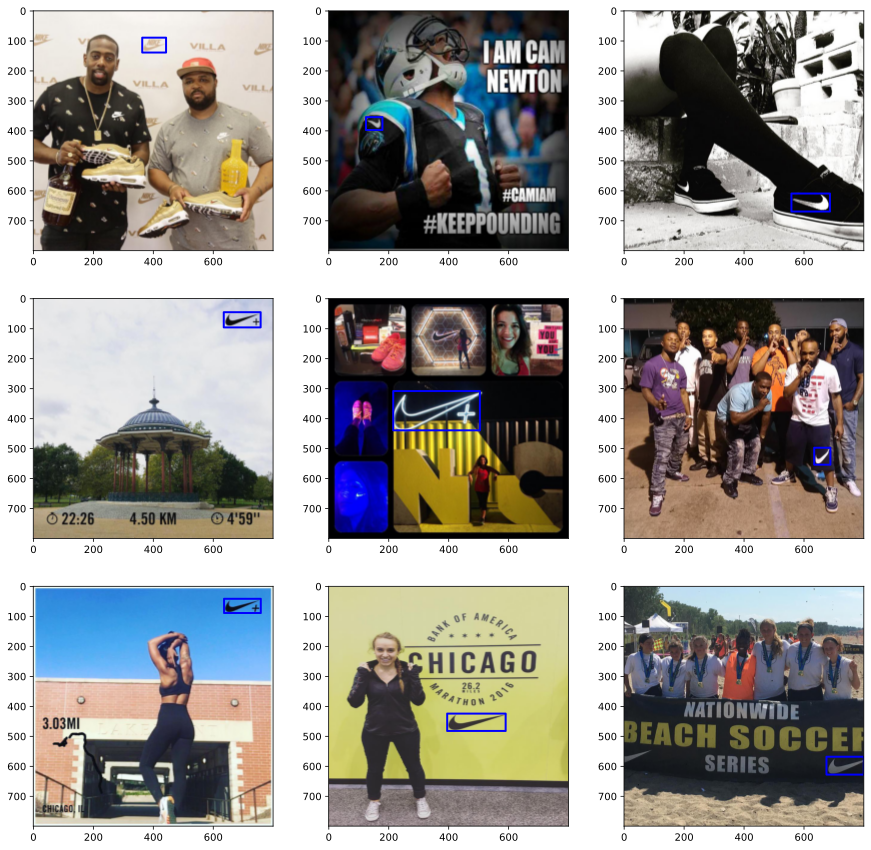

In [26]:
"""
Some plots of true bounding boxes
"""
fig, axs = plt.subplots(3,3,figsize = (15,15))
rand = np.random.randint(0,9300)
for i, ax in enumerate(fig.axes):
  show_true_box(*coco_data_test[i+rand])

####Training


In [33]:
"""
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
i = 0
for imgs, annotations in train_loader:
    i += 1
    if i == 2:
      break;
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(imgs[1].max())

print("bro")
"""
print("Only with train set")

Only with train set


In [29]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Define RPN 


"""
replace the classifier with a new one, that has
num_classes which is user-defined
"""

"""
num_classes = len(train_label_data_df["label"].unique()) + 1  # classes + background


backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).backbone

# FasterRCNN needs to know the number of

backbone.out_channels = 256

anchor_generator = AnchorGenerator(sizes=[(32, 48, 64, 96,128,192, 256) for i in range(5)],
                                   aspect_ratios=[(0.2,0.4,0.5,0.6,0.7,0.8,1,1.2,1.4) for i in range(5)])

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

fasterRCNN = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   rpn_fg_iou_thresh= 0.7, rpn_bg_iou_thresh=0.3,
                   rpn_batch_size_per_image=48, # use fewer proposals
                   rpn_positive_fraction = 0.4,
                   rpn_pre_nms_top_n_train=200,rpn_pre_nms_top_n_test=100,
                   rpn_post_nms_top_n_train=160,rpn_post_nms_top_n_test = 80,
                   rpn_nms_thresh = 0.7,box_batch_size_per_image = 36,box_positive_fraction = 0.4,)

# move model to the right device
fasterRCNN.to(device)
"""

print("Run only if you wish to replicate the training.")

Run only if you wish to replicate the training.


In [30]:

"""
# construct an optimizer
params = [p for p in fasterRCNN.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=2,
                                               gamma=0.01)

# let's train it for 10 epochs
num_epochs = 15


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(fasterRCNN, optimizer, train_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(fasterRCNN, test_loader, device=device)
    torch.save(fasterRCNN, f'{base_dir}/Saved_Models/FasterRCNN_Mobilenet5/epoch_{epoch}.pkl')

"""

print("Run only for training model")

Run only for training model


####Testing


In [31]:
#load pytorch model

fasterRCNN = torch.load(f"{base_dir}/Saved_Models/Resnet4/epoch_2.pkl")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
fasterRCNN.to(device)

print("Model Loaded Correctly")

Model Loaded Correctly


In [37]:
import cv2

import matplotlib.patches as patches

def show_all_bbox(model, img, annots = None):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():

        prediction = model([img.to(device)])
    if annots:
      show_true_box(img,annots)
    else: 
      img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
      img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
      img = np.array(img)  # tensor → ndarray
      ax.imshow()
    print(prediction)

    try:
      for i in range(len(prediction[0]["scores"])):
      
        box = prediction[0]["boxes"][i]
        x, y = box[0],box[1]
        width,height = box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                        width, height,
                                        linewidth = 3,
                                        edgecolor = 'r',
                                        facecolor = 'none')
            
            
            
        label = int2str[prediction[0]['labels'][i].item()]
        ax.set_title(label)
        ax.add_patch(rect)
    except: print("No labels")


        

[{'boxes': tensor([[484.3139, 518.3182, 526.8212, 591.1523]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9140], device='cuda:0')}]
[{'boxes': tensor([[550.5361, 547.1420, 726.7037, 660.4706]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}]
[{'boxes': tensor([[333.4470, 236.5425, 473.8582, 358.4079]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}]
[{'boxes': tensor([[126.2375,  52.4509, 203.7821, 132.3999]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}]
[{'boxes': tensor([[426.3621, 396.3995, 479.7656, 470.8363]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}]
[{'boxes': tensor([[561.3306, 507.0996, 757.9622, 800.0000]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9598], device='cuda:0')}]
[{'b

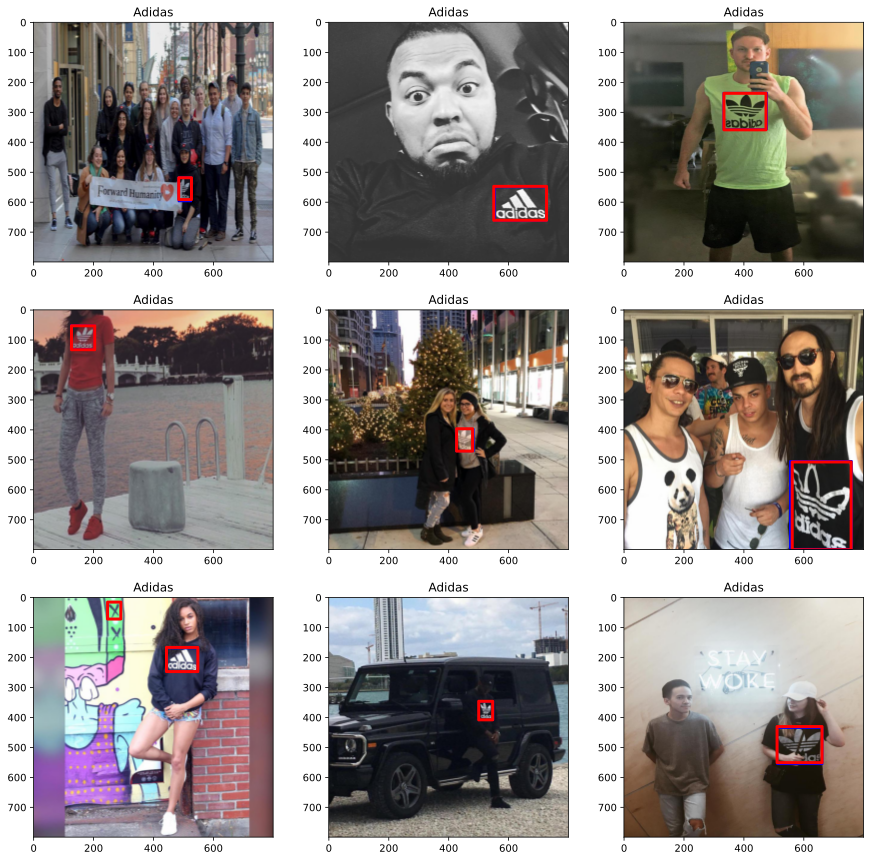

In [40]:
"""
Lets plot all the instances of bounding boxes
"""

fig, axs = plt.subplots(3,3,figsize = (15,15))
rand = np.random.randint(0,9300)
for i, ax in enumerate(fig.axes):
  show_all_bbox(fasterRCNN,*coco_data_test[i+rand])

In [41]:


def showbbox(model, img, annots = None):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():

        prediction = model([img.to(device)])

    if annots:
      show_true_box(img,annots)
    else: 
      img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
      img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
      img = np.array(img)  # tensor → ndarray
      ax.imshow()
        
    try:
      print(prediction)
      if prediction[0]["scores"][0]:
        box = prediction[0]["boxes"][0]
        x, y = box[0],box[1]
        width,height = box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                        width, height,
                                        linewidth = 3,
                                        edgecolor = 'r',
                                        facecolor = 'none')
            
            
            
        label = prediction[0]['labels'][0].item()
        ax.set_title(int2str[label])
        ax.add_patch(rect)
        print(f"Score {prediction[0]['scores'][0]}")
    except: print("No labels")


[{'boxes': tensor([[484.3139, 518.3182, 526.8212, 591.1523]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9140], device='cuda:0')}]
Score 0.9139886498451233
[{'boxes': tensor([[550.5361, 547.1420, 726.7037, 660.4706]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}]
Score 0.9935874938964844
[{'boxes': tensor([[333.4470, 236.5425, 473.8582, 358.4079]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}]
Score 0.9942495822906494
[{'boxes': tensor([[126.2375,  52.4509, 203.7821, 132.3999]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}]
Score 0.9928333759307861
[{'boxes': tensor([[426.3621, 396.3995, 479.7656, 470.8363]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}]
Score 0.9935698509216309
[{'boxes': tensor([[561.3306, 507.0996, 757.9

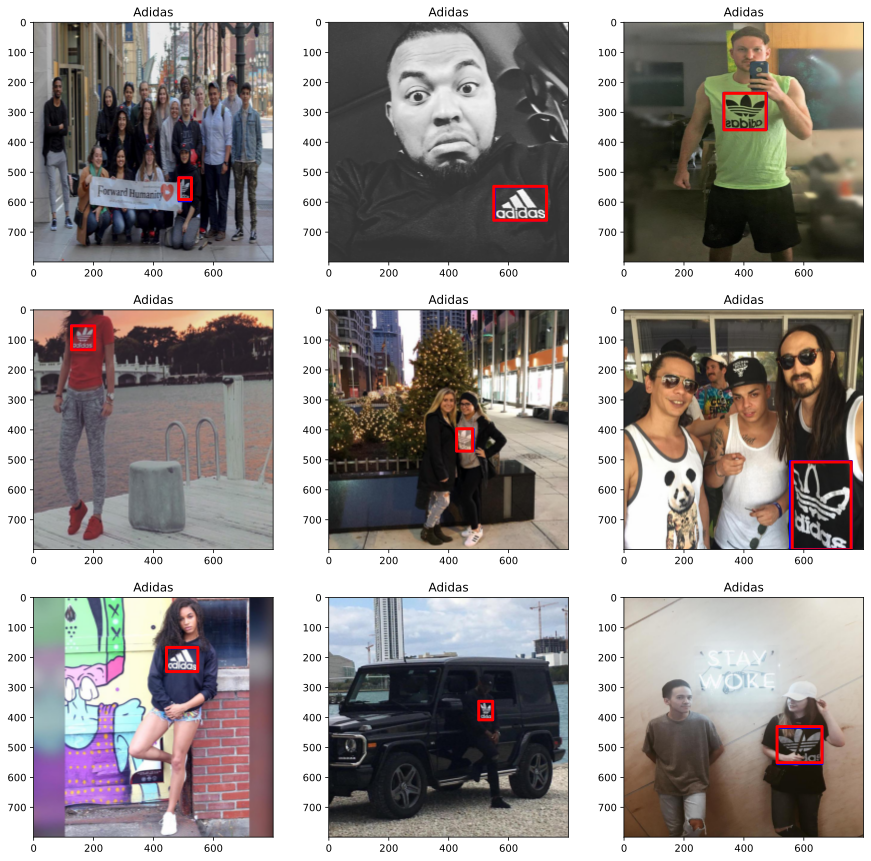

In [42]:
fig, axs = plt.subplots(3,3,figsize = (15,15))

for i, ax in enumerate(fig.axes):
  showbbox(fasterRCNN,*coco_data_test[i+rand])

In [43]:
def select_best_box(annots, thresh = 0.1):
    if annots["scores"].nelement() == 0:
      return torch.tensor([0,0,0,0]).to(device),torch.tensor([]).to(device)
    if annots["scores"][0] < thresh:
      return torch.zeros(4, dtype = torch.float32).to(device), torch.tensor([0]).to(device)
    return annots["boxes"][0], annots["labels"][0]


def IoU(box_true,box_pred):
  if box_true.nelement() == 0 and box_pred.nelement() == 0:
    return 1
  elif box_true.nelement() > 0 and box_pred.nelement() > 0:
    box_true = box_true[0]
    xA = max(box_true[0], box_pred[0])
    yA = max(box_true[1], box_pred[1])
    xB = min(box_true[2],box_pred[2])
    yB = min(box_true[3],box_pred[3])


    intersection = max(0, xB - xA) * max(0, yB-yA)
    area1 = (box_true[2]-box_true[0]+1) * (box_true[3]-box_true[1]+1)
    area2 = (box_pred[2]-box_pred[0]+1) * (box_true[3]-box_pred[1]+1)

    return (intersection/(area1 + area2 - intersection)).item()
  return 0


        

In [100]:
fasterRCNN.eval()
predictions = []
for img, annots in coco_data_test:
    with torch.no_grad():
      predictions.append(fasterRCNN([img.to(device)]))

In [101]:
annotations = [annots for img, annots in coco_data_test]

In [102]:
test_data = pd.DataFrame(annotations)

def to_list(x):
  try: 
    return x.tolist()[0]
  except: return []

  
test_data = pd.concat([test_data,pd.DataFrame(predictions)[0].apply(pd.Series).rename({"boxes": "boxes_hat", "labels" : "labels_hat"},axis =1)], axis = 1)



In [103]:
"""
Change Tensor format to lists for easier operating
"""

test_data["boxes"] = test_data["boxes"].apply(to_list)
test_data["labels"] = test_data["labels"].apply(to_list)
test_data["image_id"] = test_data["image_id"].apply(lambda x: x.tolist()[0])
test_data["area"] = test_data["area"].apply(to_list)
test_data["iscrowd"] = test_data["iscrowd"].apply(to_list)

test_data["boxes_hat"] = test_data["boxes_hat"].apply(lambda x: x.tolist())
test_data["labels_hat"] = test_data["labels_hat"].apply(lambda x: x.tolist())
test_data["scores"] = test_data["scores"].apply(lambda x: x.tolist())



In [104]:
test_data.to_csv(data_dir + "predictions_test_resnet_new.csv",index = False)

### New Test Set

An extra set of 800 images was labelled with all bounding box instances to predict the algorithms performance on a set that represents a more accurate object detection task . 

In [49]:
with open(data_dir + "extra_Data/test/_annotations.coco.json") as f: 
  test_extra = json.load(f)



In [50]:
"""
Json info to dataframe
"""
extra_image_df = pd.DataFrame(test_extra["images"])
extra_label_df = pd.DataFrame(test_extra["annotations"])

extra_label_df.head()

id  image_id  category_id  ...      area  segmentation iscrowd
0   0         0            6  ...   4200.00            []       0
1   1         1            3  ...  75842.25            []       0
2   2         2            7  ...  33860.50            []       0
3   3         3            4  ...  35100.00            []       0
4   4         4           11  ...   6923.00            []       0

[5 rows x 7 columns]

In [51]:
"""
Remapping of logo numbers to the way it was trained on 
"""
str2int = {v: k for k,v in int2str.items()}

int2str_new = {cat["id"]: cat["name"] for cat in test_extra["categories"][1:]}


In [52]:
extra_label_df["label"] = extra_label_df["category_id"].apply(lambda x: int2str_new[x])
extra_label_df["category_id"] = extra_label_df["label"].apply(lambda x: str2int[x])


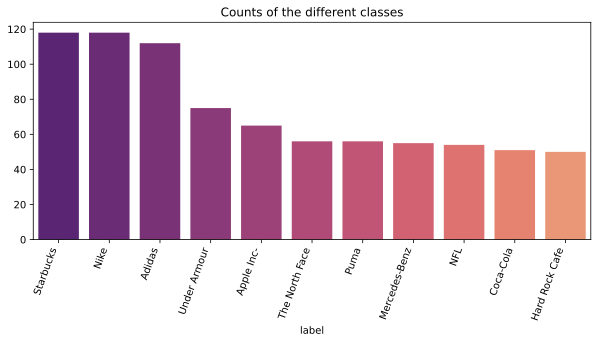

In [94]:
counts_extra = count_plot(extra_label_df,"label")

In [95]:
extra_label_df["bbox_ratio"] = extra_label_df["area"]/(800**2)


In [96]:
extra_label_df = extra_label_df.loc[extra_label_df["bbox_ratio"] < 0.4]

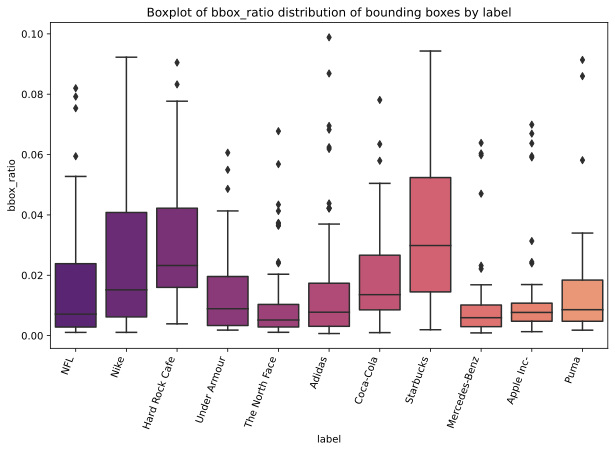

In [97]:
zoom = extra_label_df.loc[extra_label_df["bbox_ratio"] < 0.1]
dist_by_class(zoom,"label","bbox_ratio")


In [98]:
test_extra["annotations"] = extra_label_df[test_extra["annotations"][0].keys()].to_dict("records")


In [99]:
with open(data_dir + "extra_Data/test/annotationsFinal.json","w") as file:
  json.dump(test_extra, file)


#### Lets test

In [65]:
coco_data_test_extra = myOwnDataset(root =data_dir + "extra_Data/test", annotation = data_dir + "extra_Data/test/annotationsFinal.json",transforms=t.Compose([
                      t.ToTensor()
                  ]))

extra_test_loader = torch.utils.data.DataLoader(coco_data_test,batch_size=12, shuffle=True,collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [66]:
import cv2

import matplotlib.patches as patches

def show_all_bbox(model, img, annots = None):
  # The img entered is a tensor in the 0-1 range        
  model.eval()
  #print(annots)
  with torch.no_grad():

      prediction = model([img.to(device)])
  if annots:
    show_true_boxes(annots)
  else: print("No real label")
  img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
  img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
  img = np.array(img)  # tensor → ndarray

  labels = []
  try:
    for i in range(len(prediction[0]["boxes"])):
      box = prediction[0]["boxes"][i]
      x, y = box[0],box[1]
      width,height = box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y),
                                        width, height,
                                        linewidth = 3,
                                        edgecolor = 'r',
                                        facecolor = 'none')
            
            
            
      labels.append(int2str[prediction[0]['labels'][i].item()])
      ax.set_title(labels)
      ax.add_patch(rect)
  except: print("No labels")
  ax.imshow(img)



def show_true_boxes(annotation,edgecolor = "b"):
  try:
    for i in range(len(annotation["boxes"])):
      print(annotation)
      box = annotation["boxes"][i]
      x, y = box[0],box[1]
      width,height = box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y),
                                        width, height,
                                        linewidth = 2,
                                        edgecolor = 'b',
                                        facecolor = 'none')
            
      ax.add_patch(rect)
  except: print("No labels")


{'boxes': tensor([[570.0000, 230.0000, 630.5000, 261.0000]]), 'labels': tensor([3]), 'image_id': tensor([79]), 'area': tensor([1875.5000]), 'iscrowd': tensor([0])}
{'boxes': tensor([[  0.0000, 354.0000,  50.0000, 428.0000],
        [730.0000, 360.0000, 799.5000, 451.0000],
        [ 94.0000, 374.0000, 185.0000, 455.5000],
        [345.0000, 378.0000, 442.0000, 454.0000],
        [588.0000, 376.0000, 687.5000, 466.0000],
        [220.0000, 382.0000, 309.0000, 459.0000],
        [466.0000, 387.0000, 565.5000, 464.0000]]), 'labels': tensor([10, 10, 10, 10, 10, 10, 10]), 'image_id': tensor([80]), 'area': tensor([3700.0000, 6324.5000, 7416.5000, 7372.0000, 8955.0000, 6853.0000,
        7661.5000]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])}
{'boxes': tensor([[  0.0000, 354.0000,  50.0000, 428.0000],
        [730.0000, 360.0000, 799.5000, 451.0000],
        [ 94.0000, 374.0000, 185.0000, 455.5000],
        [345.0000, 378.0000, 442.0000, 454.0000],
        [588.0000, 376.0000, 687.5000, 466.00

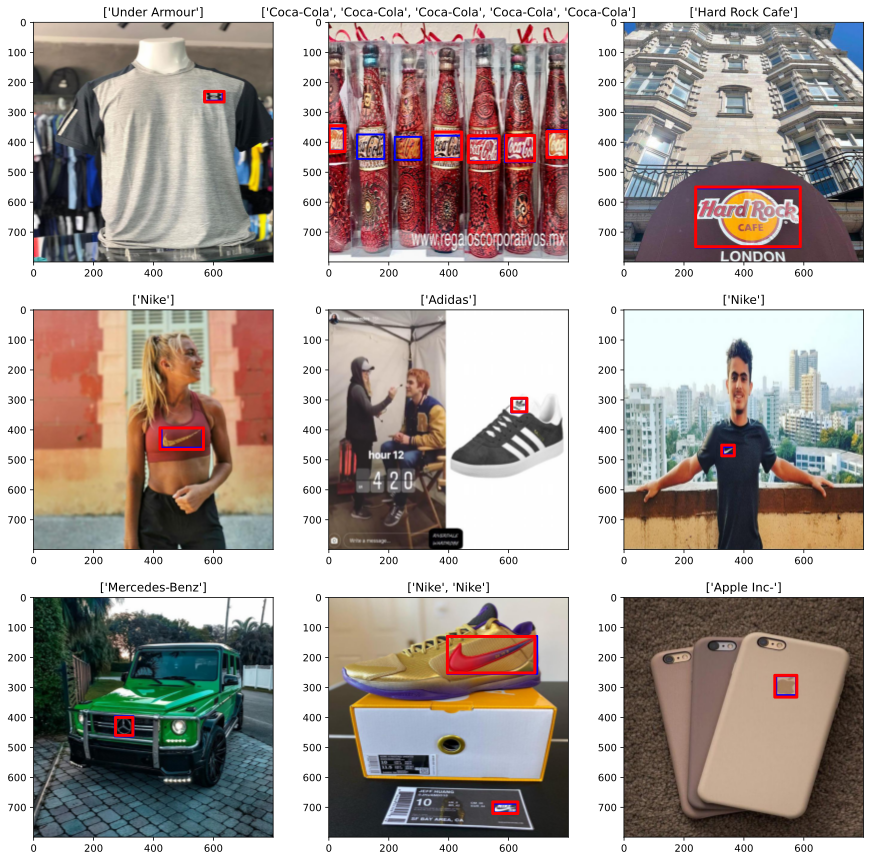

In [68]:
from coco_eval import evaluate

fig, axs = plt.subplots(3,3,figsize = (15,15))
rand = np.random.randint(0,600)
for i, ax in enumerate(fig.axes):
  show_all_bbox(fasterRCNN,*coco_data_test_extra[i+rand])

In [73]:
fasterRCNN.eval()
predictions = []
annotations = []
for img, annots in coco_data_test_extra:
  with torch.no_grad():
    predictions.append(fasterRCNN([img.to(device)]))
    annotations.append(annots)

In [84]:
test_data_extra = pd.DataFrame(annotations)

test_data_extra = pd.concat([test_data_extra,pd.DataFrame(predictions)[0].apply(pd.Series).rename({"boxes": "boxes_hat", "labels" : "labels_hat"},axis =1)], axis = 1)

test_data_extra

boxes  ...                                             scores
0    [[tensor(514.), tensor(604.), tensor(574.), te...  ...                  [tensor(0.9559, device='cuda:0')]
1    [[tensor(163.), tensor(469.), tensor(641.5000)...  ...  [tensor(0.9908, device='cuda:0'), tensor(0.307...
2    [[tensor(374.), tensor(442.), tensor(655.), te...  ...                  [tensor(0.3030, device='cuda:0')]
3    [[tensor(275.), tensor(513.), tensor(535.), te...  ...                  [tensor(0.9686, device='cuda:0')]
4    [[tensor(207.), tensor(347.), tensor(287.5000)...  ...  [tensor(0.9861, device='cuda:0'), tensor(0.694...
..                                                 ...  ...                                                ...
586  [[tensor(344.), tensor(378.), tensor(436.5000)...  ...                  [tensor(0.9940, device='cuda:0')]
587  [[tensor(445.), tensor(293.), tensor(668.), te...  ...  [tensor(0.7285, device='cuda:0'), tensor(0.236...
588  [[tensor(382.), tensor(228.), tensor(519.), te...  ...                  [tensor(0.9310, device='cuda:0')]
589  [[tensor(96.), tensor(257.), tensor(149.5000),...  ...                  [tensor(0.9981, device='cuda:0')]
590  [[tensor(355.), tensor(90.), tensor(422.), ten...  ...                  [tensor(0.9612, device='cuda:0')]

[591 rows x 8 columns]

In [101]:
"""
Change Tensor format to lists for easier operating
"""

test_data_extra["boxes"] = test_data_extra["boxes"].apply(lambda x: [i.tolist() for i in x])
test_data_extra["labels"] = test_data_extra["labels"].apply(lambda x: [i.tolist() for i in x])
test_data_extra["image_id"] = test_data_extra["image_id"].apply(lambda x: x.tolist()[0])
test_data_extra["area"] = test_data_extra["area"].apply(lambda x: [i.tolist() for i in x])
test_data_extra["iscrowd"] = test_data_extra["iscrowd"].apply(lambda x: [i.tolist() for i in x])

test_data_extra["boxes_hat"] = test_data_extra["boxes_hat"].apply(lambda x: x.tolist())
test_data_extra["labels_hat"] = test_data_extra["labels_hat"].apply(lambda x: x.tolist())
test_data_extra["scores"] = test_data_extra["scores"].apply(lambda x: x.tolist())



In [102]:
test_data_extra.to_csv(data_dir + "extra_preds.csv",index = False)